# Introduction

**ML model for emulating microphysics in supercell (climate) test case using Keras**

* Microphysics consits of 4 flow variables - temperature, water vapor, cloud water (liquid), and precipitation/rain (liquid).

* **Objective**: Emulate the evolution of microphysics of a cell from the information from its neighboring cells in supercell (climate) test case. [Kessler scheme](https://doi-org.ornl.idm.oclc.org/10.1016/0169-8095(94)00090-Z) is used for the actual emulation.

* **Input data**: Microphysics of 1D cell stencil ($3 \times 1$) for a given cell
    - Size of a single input to NN model: $[N_{\text{micro}} \times N_{\text{coarse stencil cells} }] = [4 \times 3]$ for 2D/3D simulation
* **Output data**: Microphysics of given cell after emmulation (at next time step)
    - Size of corresponding output from NN model: $[N_{\text{micro}}] = [4]$ for 2D/3D simulation
* **Training data size**:
    - Input:  $12 \times N_{\text{train}}$
    - Output: $4  \times N_{\text{train}}$

* **Data generation**:
    - Data will be downloaded.
    - If the user would like to change the amount of data, see the notebook [1_miniWeatherML_supercell_dataAcqu.ipynb](1_miniWeatherML_supercell_dataAcqu.ipynb)

**By MGM, ORNL**

2022 April 05

**Edited:**
* 2022 Apr. 05:
    * initial code complete

# TO DO

* Plot input & output data
* Perspective of the data that is being dealt with
* Movie of flow field evolution
* Cartoon of microphysics

# Import libraries

In [1]:
# for math
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# for ML (Keras - TensorFlow backend)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'    # to hide TF info messages
# # check for GPU use (***)
# import tensorflow as tf
# print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Nadam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import model_from_json

# for plotting
import matplotlib.pyplot as plt

# Set parameters & hyperparameters

In [2]:
# For loading data
Ntot            = np.int(1e6) # number of total data points

# For neural network
n_inputs        = 12     # number of inputs
n_outputs       = 4      # number of outputs
nneurons        = 10     # number of neurons in MLP (***)
leakyReLU_alpha = 0.1    # slope (negative) of LeakyReLU activation function
nepoch          = 10     # number of epochs during training (***)
# (***)
batch_size      = 1000   # mini-batch size for data during training
n_val           = 0.1    # split for validation data during training (in %)

# Saving
saveNN          = True   # save NN model; data scaling values
fname_NN        = f'Data_models/supercell_micro_Keras'
saveFig         = True  # save ML prediction figure (and others - edit accordingly)
fname_Fig       = 'Figs/supercell_micro_Keras'

if saveFig:
    if ( not os.path.isdir(f'Figs/') ): 
        !mkdir Figs
if saveNN:
    if ( not os.path.isdir(f'Data_models/') ):
        !mkdir Data_models

# Load full data and scale

## Download data if ncessary

In [3]:
path = f'Data_training/supercell_micro_Ntrain{Ntot}.npz'
data_link  = "https://www.dropbox.com/s/ns3l8dg3vc0e2th/supercell_micro_Ntrain1000000.npz?dl=0"

if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}\nSee cell below for data download commands in Google Colab\nExiting program...")
    if ( not os.path.isdir(f'Data_training/') ): 
        !mkdir Data_training
    !wget {data_link} -O supercell_micro_Ntrain1000000.npz
    !mv supercell_micro_Ntrain*.npz Data_training/

## Load full data and scale

In [4]:
npzfile = np.load(path)
train_IP = npzfile['datatrain_IP'].T
train_OP = npzfile['datatrain_OP'].T
test_IP = npzfile['datatest_IP'].T
test_OP = npzfile['datatest_OP'].T

In [5]:
# prepare dataset with input and output scalers, can be none
def get_scaleddataset(train_IP, train_OP, test_IP, test_OP, input_scaler, output_scaler):
    # scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(train_IP)
        # transform training dataset
        train_IP = input_scaler.transform(train_IP)
        # transform test dataset
        test_IP = input_scaler.transform(test_IP)
    if output_scaler is not None:
        # fit scaler on training dataset
        output_scaler.fit(train_OP)
        # transform training dataset
        train_OP = output_scaler.transform(train_OP)
        # transform test dataset
        test_OP = output_scaler.transform(test_OP)
    return train_IP, train_OP, test_IP, test_OP, input_scaler, output_scaler

In [6]:
# Scale data
train_IP, train_OP, test_IP, test_OP, input_scalar, output_scalar = get_scaleddataset(train_IP, train_OP, 
                                                                                      test_IP, test_OP, 
                                                                                      MinMaxScaler(), MinMaxScaler())
# Save scaling measures (min-max)
if saveNN:
    sclrArray = np.append(input_scalar.data_min_.reshape(n_inputs,1),input_scalar.data_max_.reshape(n_inputs,1),axis=1)
    sclrFname = path[:-4]+'_input.txt'
    np.savetxt(sclrFname, sclrArray, fmt="%s")
    sclrArray = np.append(output_scalar.data_min_.reshape(n_outputs,1),output_scalar.data_max_.reshape(n_outputs,1),axis=1)
    sclrFname = path[:-4]+'_output.txt'
    np.savetxt(sclrFname, sclrArray, fmt="%s")

# Define the network

In [7]:
model = Sequential()
model.add( Dense(nneurons,input_dim=n_inputs,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=leakyReLU_alpha) )

# model.add( Dense(nneurons,kernel_initializer="RandomUniform") )
# model.add( LeakyReLU(alpha=leakyReLU_alpha) )

# # (***)
# model.add( Dense(nneurons,kernel_initializer="RandomUniform") )
# model.add( LeakyReLU(alpha=leakyReLU_alpha) )

model.add( Dense(n_outputs,kernel_initializer="RandomUniform") )

model.compile(loss='mse', optimizer=Nadam())

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                130       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________
None


# Train the model

In [8]:
history = model.fit(train_IP, train_OP, epochs=nepoch, batch_size=batch_size, validation_split=n_val, verbose=1)

Epoch 1/10
900/900 [==============================] - 2s 1ms/step - loss: 0.0295 - val_loss: 3.0866e-04
Epoch 2/10
900/900 [==============================] - 1s 965us/step - loss: 1.7305e-04 - val_loss: 4.7861e-05
Epoch 3/10
900/900 [==============================] - 1s 1ms/step - loss: 4.2570e-05 - val_loss: 3.2830e-05
Epoch 4/10
900/900 [==============================] - 1s 1ms/step - loss: 3.0919e-05 - val_loss: 2.4310e-05
Epoch 5/10
900/900 [==============================] - 1s 1ms/step - loss: 2.2694e-05 - val_loss: 1.7031e-05
Epoch 6/10
900/900 [==============================] - 1s 1ms/step - loss: 1.5918e-05 - val_loss: 1.0624e-05
Epoch 7/10
900/900 [==============================] - 1s 1ms/step - loss: 9.8261e-06 - val_loss: 5.8033e-06
Epoch 8/10
900/900 [==============================] - 1s 1ms/step - loss: 5.6306e-06 - val_loss: 3.5162e-06
Epoch 9/10
900/900 [==============================] - 1s 1ms/step - loss: 3.5529e-06 - val_loss: 2.6152e-06
Epoch 10/10
900/900 [=========

# Evaluate the model & prediction

In [9]:
# evaluate the keras model
train_mse = model.evaluate(train_IP, train_OP, verbose=0)
test_mse = model.evaluate(test_IP, test_OP, verbose=0)
print('Train: %4.3e, Test: %4.3e' % (train_mse, test_mse))

Train: 3.797e-06, Test: 3.675e-06


In [10]:
# Predict output of test input
test_OP_ML = model.predict(test_IP)

# Plotting the results

## Loss during training

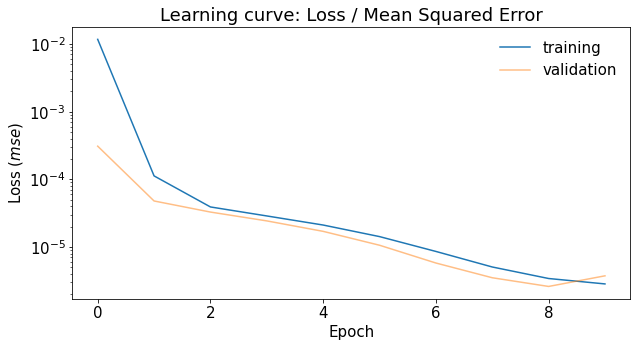

In [11]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,figsize=(10,5),facecolor="1")
axs.set_title('Learning curve: Loss / Mean Squared Error')
axs.plot(history.history['loss'], label='training')
axs.plot(history.history['val_loss'], label='validation', alpha=0.5)
axs.set_xlabel('Epoch'); axs.set_ylabel(f'Loss ($mse$)')
axs.set_yscale('log')
axs.legend(frameon=False);

## ML prediction of testing data

In [12]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

### Plot predicted output 
* (in scaled form if applicable)

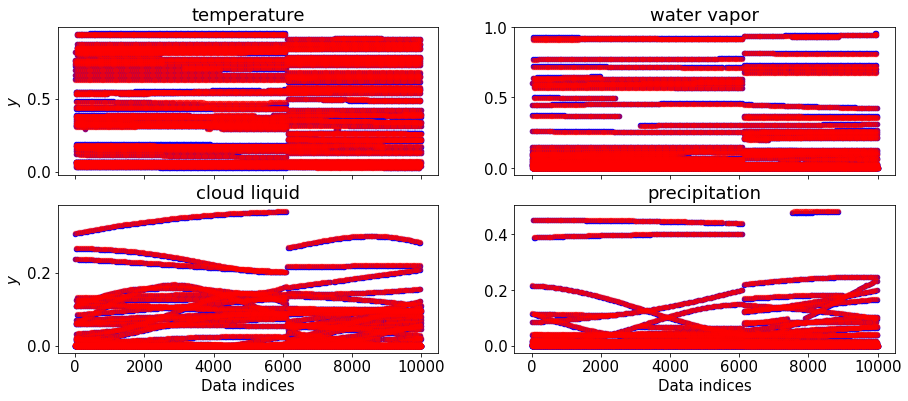

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(np.arange(1,test_OP.shape[0]+1),test_OP[:,i],color='blue',s=20)
    axs[i].scatter(np.arange(1,test_OP.shape[0]+1),test_OP_ML[:,i],color='red',s=20,alpha=0.5)
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'Data indices'); axs[3].set_xlabel(r'Data indices');
axs[0].set_ylabel(r'$y$'); axs[2].set_ylabel(r'$y$');

if saveFig: plt.savefig(f'{fname_Fig}_testOP_scaled.png', bbox_inches='tight',dpi=100)

### Correlation between true & predicted values

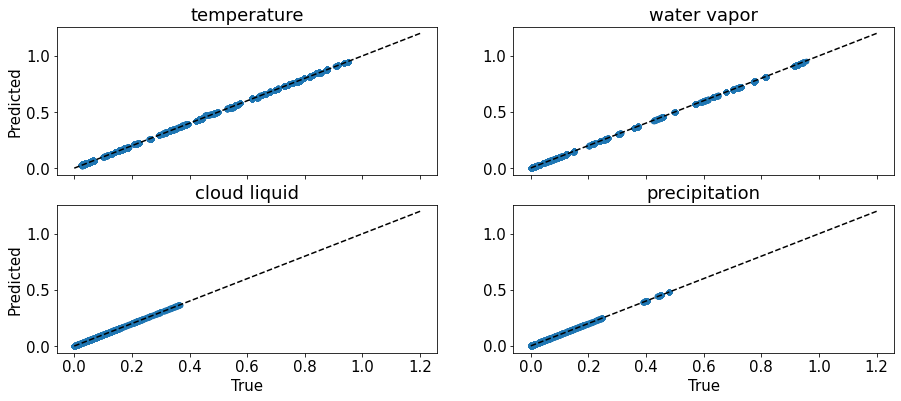

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(test_OP[:,i],test_OP_ML[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

if saveFig: plt.savefig(f'{fname_Fig}_testCorr_scaled.png', bbox_inches='tight',dpi=100)

### Plot re-scaled data

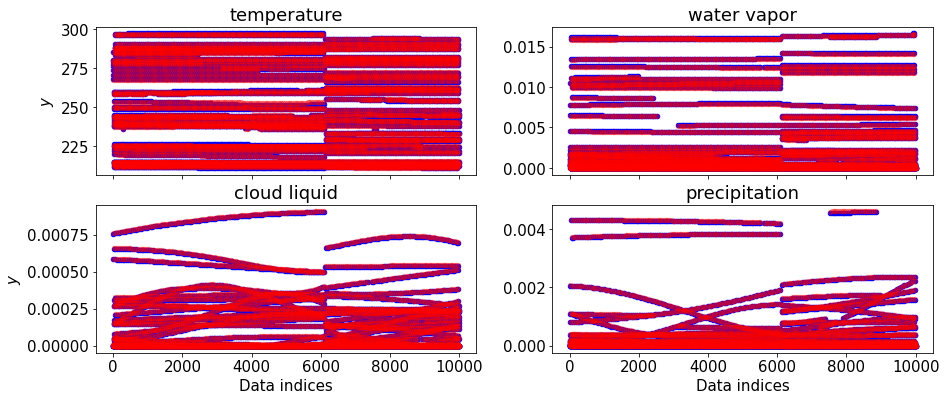

In [15]:
# get re-scaled data
test_OP_re = output_scalar.inverse_transform(test_OP)
test_OP_ML_re = output_scalar.inverse_transform(test_OP_ML)

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(np.arange(1,test_OP_re.shape[0]+1),test_OP_re[:,i],color='blue',s=20)
    axs[i].scatter(np.arange(1,test_OP_re.shape[0]+1),test_OP_ML_re[:,i],color='red',s=20,alpha=0.3)
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'Data indices'); axs[3].set_xlabel(r'Data indices');
axs[0].set_ylabel(r'$y$'); axs[2].set_ylabel(r'$y$');

### Error distribution

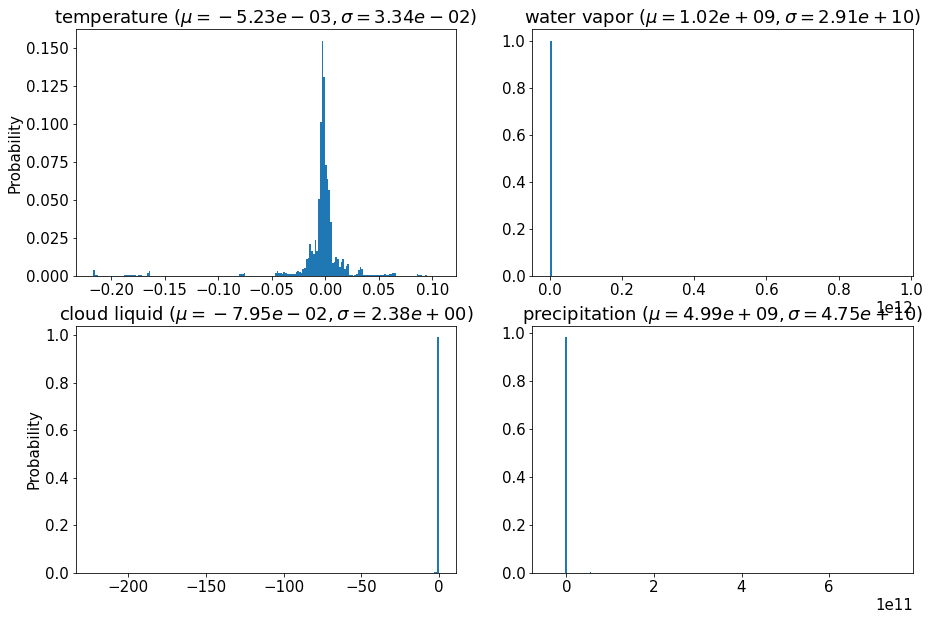

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10),facecolor="1")
axs = axs.ravel()
for i in range(4):
    err = (test_OP[:,i]-test_OP_ML[:,i]) / (test_OP[:,i] + 1e-15)
    err[test_OP[:,i]==0] = 0
    axs[i].hist(err, weights=np.ones(len(err)) / len(err),density=False, bins=200)
    axs[i].set_title(r''+titlestr[i]+' ($\mu = %4.2e , \sigma = %4.2e$)' % (np.mean(err),np.std(err)))
axs[0].set_ylabel('Probability');
axs[2].set_ylabel('Probability');
if saveFig: plt.savefig(f'{fname_Fig}_testOP_errI.png', bbox_inches='tight',dpi=200)

# Save model, weights and history

In [17]:
# serialize model to JSON
if saveNN:
    model_json = model.to_json()
    with open(f'{fname_NN}_model_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.json', 'w') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f'{fname_NN}_modelwt_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.h5')
    print('Saved model to disk')
    # save history
    np.save(f'{fname_NN}_modelhist_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.npy',history.history)

Saved model to disk


## Notes on how to load the model:

In [18]:
# # load json and create model
# json_file = open(f'Data_models/supercell_micro_model_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights(f'Data_models/supercell_micro_modelwt_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.h5')
# # load history
# history=np.load(f'Data_models/supercell_micro_modelhist_NORMip_NORMop{str(Ntot)}_Nneu{str(nneurons)}.npy',allow_pickle='TRUE').item()

# # evaluate loaded model on test data
# loaded_model.compile(loss='mse', optimizer=Nadam())